# Multilayer Perceptron vs Extreme Learning Machine
## An implementation and comparision

**import libraries**

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.neural_network import MLPRegressor
from sklearn.exceptions import ConvergenceWarning
from sklearn.utils.testing import ignore_warnings

plt.style.use("ggplot")

**Create MLP and ELM regressors**

In [2]:
class MLP(MLPRegressor):
    @ignore_warnings(category=ConvergenceWarning)
    def __init__(self, sizes=(100,), act='relu', max_i=200):
        super().__init__(hidden_layer_sizes=sizes, activation=act, max_iter=max_i)

In [3]:
class ELM(object):
    def __init__(self, hidden_units=200):
        self._hidden_units = hidden_units
        
    def train(self, X, Y):
        X = np.column_stack([X, np.ones([X.shape[0], 1])])
        self.random_weights = np.random.randn(X.shape[1], self._hidden_units)
        G = np.tanh(X.dot(self.random_weights))
        self.w_elm = np.linalg.pinv(G).dot(Y)
        
    def predict(self, X):
        X = np.column_stack([X, np.ones([X.shape[0], 1])])
        G = np.tanh(X.dot(self.random_weights))
        return G.dot(self.w_elm)

In [4]:
path = './data/air_bnb_nyc.csv'
df = pd.read_csv(path, index_col='id')
df.head()

,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
id,,,,,,,,,,,,,,,
2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,19.10.2018,0.21,6,365
2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,21.05.2019,0.38,2,355
3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,05.07.2019,4.64,1,194
5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,19.11.2018,0.10,1,0


In [5]:
#dropping NaN
df = df.dropna(axis=0)
#drop useless feature
df = df.drop(axis=1, labels=['name', 'host_id', 'host_name', 'neighbourhood', 'latitude', 'longitude', 'last_review'])
df.head()

,neighbourhood_group,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
id,,,,,,,,
2539,Brooklyn,Private room,149,1,9,0.21,6,365
2595,Manhattan,Entire home/apt,225,1,45,0.38,2,355
3831,Brooklyn,Entire home/apt,89,1,270,4.64,1,194
5022,Manhattan,Entire home/apt,80,10,9,0.10,1,0
5099,Manhattan,Entire home/apt,200,3,74,0.59,1,129


**Encode Categorical Features**

In [6]:
le = LabelEncoder()
df['neighbourhood_group'] = le.fit_transform(df['neighbourhood_group'])
df['room_type'] = le.fit_transform(df['room_type'])

In [7]:
df.head()

,neighbourhood_group,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
id,,,,,,,,
2539,1,1,149,1,9,0.21,6,365
2595,2,0,225,1,45,0.38,2,355
3831,1,0,89,1,270,4.64,1,194
5022,2,0,80,10,9,0.10,1,0
5099,2,0,200,3,74,0.59,1,129


**Feature Engineering**

In [8]:
price_div = 10000
n_review_div = df.number_of_reviews.max()
availa_div = 365

**Regularize and Normalize Data**

In [9]:
df.price = df.price / price_div
df.number_of_reviews = df.number_of_reviews / n_review_div
df.availability_365 = df.availability_365 / availa_div

**Data Preparation**

In [10]:
X = df.drop(axis=1, labels=['price'])
Y = df.price
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=32)

In [11]:
class Helper(object):
    def get_elm(self):
        return self.elm
    
    def get_mlp(self):
        return self.mlp
    
    @ignore_warnings(category=ConvergenceWarning)
    def train_both(self, X, Y, n=100):
        self.iterations = list(range(1, n+1))
        self.elm_mse = []
        self.mlp_mse = []
        for i in self.iterations:
            print(f'{i}.. ', end=' ')
            self.elm = ELM(i)
            self.elm.train(X, Y)
            self.elm_mse.append(np.mean((Y - self.elm.predict(X))**2))
            self.mlp = MLP(sizes=(50,), act='tanh', max_i=i)
            self.mlp.fit(X, Y)
            self.mlp_mse.append(np.mean((Y - self.mlp.predict(X))**2))
        return (self.elm_mse, self.mlp_mse)

**Training and Model Evaluation**

In [12]:
misc = Helper()
elm_mse, mlp_mse = misc.train_both(X_train, y_train, 100)

1..  2..  3..  4..  5..  6..  7..  8..  9..  10..  11..  12..  13..  14..  15..  16..  17..  18..  19..  20..  21..  22..  23..  24..  25..  26..  27..  28..  29..  30..  31..  32..  33..  34..  35..  36..  37..  38..  39..  40..  41..  42..  43..  44..  45..  46..  47..  48..  49..  50..  51..  52..  53..  54..  55..  56..  57..  58..  59..  60..  61..  62..  63..  64..  65..  66..  67..  68..  69..  70..  71..  72..  73..  74..  75..  76..  77..  78..  79..  80..  81..  82..  83..  84..  85..  86..  87..  88..  89..  90..  91..  92..  93..  94..  95..  96..  97..  98..  99..  100..  

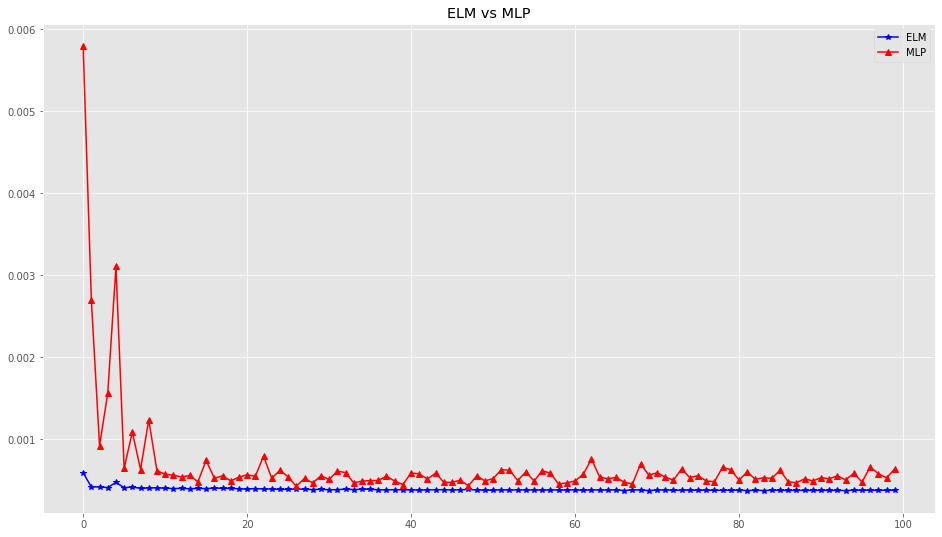

In [13]:
plt.figure(figsize=(16, 9))
plt.title("ELM vs MLP")
plt.plot(elm_mse, 'b*-', label='ELM')
plt.plot(mlp_mse, 'r^-', label='MLP')
plt.legend()
#plt.yscale('log')
plt.savefig('./data/output.png')
plt.show()

**Testing and Evaluation**

In [14]:
elm = misc.get_elm()
mlp = misc.get_mlp()

In [15]:
print(f'ELM MSE: {np.mean((y_test-elm.predict(X_test))**2)}')
print(f'MLP MSE: {np.mean((y_test-mlp.predict(X_test))**2)}')

ELM MSE: 0.00028788747489584337
MLP MSE: 0.000566095677992459
